# Catch that asteroid!

In [1]:
from IPython.display import HTML

In [2]:
HTML("""
<blockquote class="twitter-tweet" data-lang="en"><p lang="es" dir="ltr">Sobre <a href="https://twitter.com/hashtag/Florence?src=hash">#Florence</a> y los demás asteroides (ref Harris et al 2015 <a href="https://t.co/YfLdhEiqJb">https://t.co/YfLdhEiqJb</a>).  Hay que hacer mucho más <a href="https://t.co/uqj5LabQLo">https://t.co/uqj5LabQLo</a> <a href="https://t.co/NBHFAuFQAA">pic.twitter.com/NBHFAuFQAA</a></p>&mdash; Pedro Duque (@astro_duque) <a href="https://twitter.com/astro_duque/status/903241796477743104">August 31, 2017</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>
""")

In [3]:
HTML("""
<blockquote class="twitter-tweet" data-lang="en"><p lang="es" dir="ltr">La <a href="https://twitter.com/esa_es">@esa_es</a> ha preparado un resumen del asteroide <a href="https://twitter.com/hashtag/Florence?src=hash">#Florence</a> 😍 <a href="https://t.co/Sk1lb7Kz0j">pic.twitter.com/Sk1lb7Kz0j</a></p>&mdash; AeroPython (@AeroPython) <a href="https://twitter.com/AeroPython/status/903197147914543105">August 31, 2017</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>
""")

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("pybonacci")

from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

from poliastro.bodies import *
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter, plot

EPOCH = Time("2017-09-01 12:05:50")

<div class="alert alert-warning">
<ul>
<li>I miss a `.plot` method</li>
<li>I miss docs in `from_body_ephem`</li>
<li>Should I be able to select the epoch in `neos.*.orbit_from_name`?</li>
<li>May I have a high level function so I do not have to decide which implementation I use, or switch with a string? Perhaps living in `Orbit`?</li>
<li>May I customize the color of the lines in an easy way?</li>
<li>Displaying an `OrbitPlotter` object in the Jupyter notebook should show the plot</li>
<li>More explicit `NotImplementedError`: rotating already set frames is not supported</li>
<li>String representation is confusing for hyperbolic orbits</li>
<li>Hyperbolic orbits are broken again</li>
</ul>
</div>

In [5]:
earth = Orbit.from_body_ephem(Earth, EPOCH)
earth

1 x 1 AU x 23.4 deg orbit around Sun (☉)

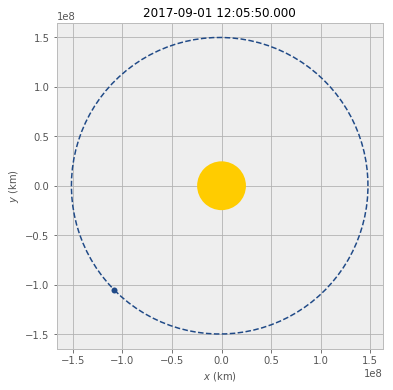

In [6]:
plot(earth)

In [7]:
from poliastro.neos import neows

In [8]:
florence = neows.orbit_from_name("Florence")
florence

1 x 3 AU x 22.2 deg orbit around Sun (☉)

Two problems: the epoch is not the one we desire, and the inclination is with respect to the ecliptic!

In [9]:
florence.epoch

<Time object: scale='utc' format='iso' value=2017-08-30 06:19:34.000>

In [10]:
florence.inc

<Quantity 22.15078266856838 deg>

We first propagate:

In [11]:
florence = florence.propagate(EPOCH - florence.epoch)
florence

1 x 3 AU x 22.2 deg orbit around Sun (☉)

In [12]:
florence.epoch

<Time object: scale='utc' format='iso' value=2017-09-01 12:05:50.000>

And now we have to another reference frame.

In [13]:
from astropy.coordinates import GCRS, ICRS, HeliocentricTrueEcliptic, CartesianRepresentation, CartesianDifferential

In [14]:
florence_hte = HeliocentricTrueEcliptic(
    x=florence.r[0], y=florence.r[1], z=florence.r[2],
    d_x=florence.v[0], d_y=florence.v[1], d_z=florence.v[2],
    representation=CartesianRepresentation,
    differential_cls=CartesianDifferential
)
florence_hte

<HeliocentricTrueEcliptic Coordinate (equinox=J2000.000): (x, y, z) in km
    (  1.48511452e+08, -45681114.35881438,  7497451.05617513)
 (d_x, d_y, d_z) in km / s
    ( 5.31595113,  31.85092237,  12.73089148)>

In [15]:
florence_icrs_trans = florence_hte.transform_to(ICRS)
florence_icrs_trans.representation = CartesianRepresentation
florence_icrs_trans

<ICRS Coordinate: (x, y, z) in km
    (  1.49582133e+08, -44488421.14750969, -11151301.37856153)
 (v_x, v_y, v_z) in km / s
    ( 5.31379956,  24.15824416,  24.35074871)>

In [16]:
florence_icrs = Orbit.from_vectors(
    Sun,
    r=[florence_icrs_trans.x, florence_icrs_trans.y, florence_icrs_trans.z] * u.km,
    v=[florence_icrs_trans.v_x, florence_icrs_trans.v_y, florence_icrs_trans.v_z] * (u.km / u.s),
    epoch=florence.epoch
)
florence_icrs

1 x 3 AU x 44.6 deg orbit around Sun (☉)

In [17]:
florence_icrs.rv()

(<Quantity [  1.49582133e+08, -4.44884211e+07, -1.11513014e+07] km>,
 <Quantity [  5.31379956, 24.15824416, 24.35074871] km / s>)

Let us compute the distance between Florence and the Earth:

In [18]:
from poliastro.util import norm

In [19]:
norm(florence_icrs.r - earth.r)

<Quantity 13735002.868103746 km>

<div class="alert alert-danger">This result does not match the one obtained in Horizons. See discussion at https://github.com/poliastro/poliastro/issues/222</div>

In [20]:
florence_icrs_horizons = Orbit.from_vectors(
    Sun,
    r=[ 1.462711616972699E+08,  -5.387988504142999E+07,  -2.090697067522797E+07] * u.km,
    v=[7.400856444295337E+00,   2.345944614346594E+01,   2.412379105662438E+01] * u.km / u.s,
    epoch=EPOCH
)
florence_icrs_horizons.rv()

(<Quantity [  1.46271162e+08, -5.38798850e+07, -2.09069707e+07] km>,
 <Quantity [  7.40085644, 23.45944614, 24.12379106] km / s>)

In [21]:
norm(florence_icrs_horizons.r - earth.r)

<Quantity 7067250.684877471 km>

<div class="alert alert-danger">This difference is consistent with what ESA says.</div>

And now we can plot! Notice the use of `.propagate` to "move" the asteroid to the moment we want to capture.

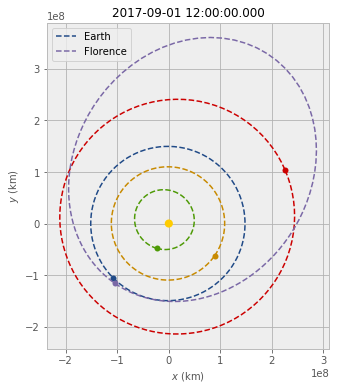

In [17]:
frame = OrbitPlotter()

frame.plot(earth, label="Earth")

frame.plot(Orbit.from_body_ephem(Mars, EPOCH))
frame.plot(Orbit.from_body_ephem(Venus, EPOCH))
frame.plot(Orbit.from_body_ephem(Mercury, EPOCH))

frame.plot(florence_icrs, label="Florence")

The difference between doing it well and doing it wrong are not minor:

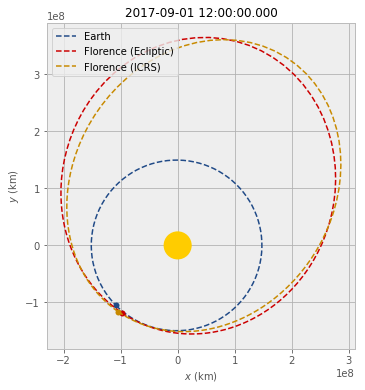

In [18]:
frame = OrbitPlotter()

frame.plot(earth, label="Earth")

frame.plot(florence, label="Florence (Ecliptic)")
frame.plot(florence_icrs, label="Florence (ICRS)")

And now let's do something more complicated: express our orbit with respect to the Earth!

In [19]:
from poliastro.coordinates import icrs_to_body_centered

In [20]:
r_h, v_h = icrs_to_body_centered(
    florence_icrs.r, florence_icrs.v,
    Earth, epoch=EPOCH, rotate_meridian=False
)
r_h, v_h

(<Quantity [  4387724.04864424, -8251840.60078145, 10061983.89303385] km>,
 <Quantity [ -1.27215869,  4.87450199, 13.32139727] km / s>)

In [21]:
florence_hyper = Orbit.from_vectors(
    Earth, r_h, v_h, epoch=EPOCH
)
florence_hyper

12255683 x -12259614 km x 86.4 deg orbit around Earth (♁)

Notice that the ephemerides of the Moon is also given in ICRS!

In [22]:
moon = Orbit.from_body_ephem(Moon, EPOCH)
moon

151218307 x -151219188 km x 23.3 deg orbit around Earth (♁)

In [23]:
moon.r_p.to(u.au)

<Quantity 1.0108319476023608 AU>

In [24]:
moon.r_a.to(u.au)

<Quantity -1.010837835886692 AU>

In [25]:
moon.a

<Quantity -440.4373990185957 km>

In [26]:
moon.ecc

<Quantity 343337.66335737886>

So we have to convert again.

In [27]:
moon = Orbit.from_body_ephem(Moon, EPOCH)
moon_icrs = ICRS(
    x=moon.r[0], y=moon.r[1], z=moon.r[2],
    v_x=moon.v[0], v_y=moon.v[1], v_z=moon.v[2],
    representation=CartesianRepresentation,
    differential_cls=CartesianDifferential
)
moon_icrs

<ICRS Coordinate: (x, y, z) in km
    (  1.41396411e+08, -49235602.25114836, -21340721.492478)
 (v_x, v_y, v_z) in km / s
    ( 11.1105857,  25.67740167,  11.05629388)>

Important to use the `obstime` attribute of `GCRS`, otherwise the system does not know where the Earth is.

In [28]:
moon_gcrs = moon_icrs.transform_to(GCRS(obstime=EPOCH))
moon_gcrs.representation = CartesianRepresentation
moon_gcrs

<GCRS Coordinate (obstime=2017-09-01 12:00:00.000, obsgeoloc=( 0.,  0.,  0.) m, obsgeovel=( 0.,  0.,  0.) m / s): (x, y, z) in km
    ( 93925.7048672, -367350.56244142, -133097.20156884)
 (v_x, v_y, v_z) in km / s
    ( 0.94089505,  0.25722025,  0.03545764)>

In [29]:
moon = Orbit.from_vectors(
    Earth,
    [moon_gcrs.x, moon_gcrs.y, moon_gcrs.z] * u.km,
    [moon_gcrs.v_x, moon_gcrs.v_y, moon_gcrs.v_z] * (u.km / u.s),
    epoch=EPOCH
)
moon

367931 x 405207 km x 19.4 deg orbit around Earth (♁)

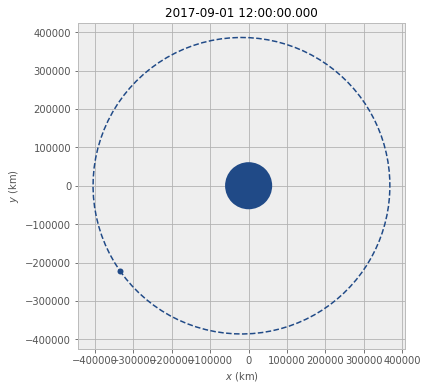

In [30]:
plot(moon)

And now for the final plot:

(-6000000, 2000000)

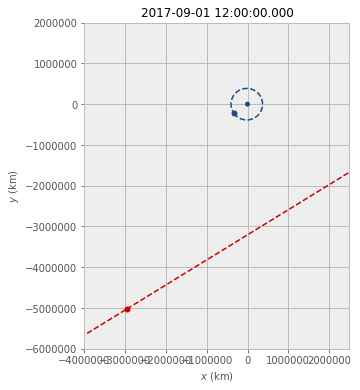

In [31]:
plt.figure()

frame = OrbitPlotter()

frame.plot(moon)
frame.plot(florence_hyper)

plt.xlim(-4000000, 2500000)
plt.ylim(-6000000, 2000000)

<p style="text-align: center; font-size: 3em"><em>Per Python ad astra ;)</em></span>